In [1]:
cd ..

/Users/flamholz/Documents/workspace/carboxecoli


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import itertools

from ast import literal_eval as make_tuple
from cobra.core import model
from cobra.flux_analysis import phenotype_phase_plane, pfba
from cobra.io import read_sbml_model
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap
from matplotlib import cm
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from typing import List, Tuple, Iterable, Any

import optslope_rubisco

from notebooks.pltconfig import *

In [3]:
# Read the slopes from an input file.
# You should first run ../optslope_rubisco/rubisco_dependence.py, which produces this file
df = pd.read_csv('optslope_rubisco/results.csv', index_col=0)

CSOURCE_SPECIAL_LABELS = {
    'glc__D': 'gluc',
    'fru': 'fruc',
    '6pgc': 'gnt',
    'r5p': 'ribo',
    'succ': 'succ',
    'xu5p__D': 'xyl',
    '2pg': 'gly$^{ate}$',
    'ac': 'ace',
    'dhap': 'gly$^{ol}$',
}
CARBON_SOURCE_LABELS = [CSOURCE_SPECIAL_LABELS.get(l[0], l[0]) for l in optslope_rubisco.CARBON_SOURCES_LIST]

KO_SPECIAL_LABELS = {
    '': 'None',
    'ACONTa|ACONTb': 'ACONT',
    'TKT1|TKT2': 'TKT',
    'G6PDH2r|PGL': 'PPP',
    'GAPD|PGK': 'GAPDH',
    'EDD|EDA': 'EDP',
}
SINGLE_KO_LABELS = [KO_SPECIAL_LABELS.get(l, l) for l in optslope_rubisco.SINGLE_KOS]

n_csources = len(optslope_rubisco.CARBON_SOURCES_LIST)
csource_dim = int(np.sqrt(n_csources))

In [4]:
# Peek at the drpiAB dEDD data just to make sure this is right.
mask = df.knockouts.str.contains('RPI')
mask &= df.knockouts.str.contains('EDD')
df[mask]

,knockouts,carbon_sources,slope
330,"('EDD|EDA', 'RPI')","('glc__D',)",2.156
330,"('EDD|EDA', 'RPI')","('fru',)",2.156
330,"('EDD|EDA', 'RPI')","('6pgc',)",14.481
330,"('EDD|EDA', 'RPI')","('r5p',)",0.000
330,"('EDD|EDA', 'RPI')","('succ',)",2.156
330,"('EDD|EDA', 'RPI')","('xu5p__D',)",15.921
330,"('EDD|EDA', 'RPI')","('2pg',)",2.156
330,"('EDD|EDA', 'RPI')","('ac',)",2.156
330,"('EDD|EDA', 'RPI')","('dhap',)",2.156


In [5]:
# Make into a square matrix of 3x3 carbon source squares suitable for a heatmap.
# See figure below to understand.
N = len(optslope_rubisco.SINGLE_KOS)
data_mat = np.zeros((3*N, 3*N)) * np.nan
for row in df.itertuples():
    kos = make_tuple(row.knockouts)
    cs = make_tuple(row.carbon_sources)
    if len(kos) == 0 or len(cs) == 0:
        continue
    
    i0 = optslope_rubisco.SINGLE_KOS.index(kos[0])
    if len(kos) == 0:
        continue
    elif len(kos) == 1:
        i1 = i0
    else:
        i1 = optslope_rubisco.SINGLE_KOS.index(kos[1])

    i2 = optslope_rubisco.CARBON_SOURCES_LIST.index(cs)

    x = 3 * i0 + i2 // 3
    y = 3 * i1 + i2 % 3
    data_mat[x, y] = row.slope

In [6]:
# A helper to make a subplot for single KO combination for deeper inspection.
def make_slopes_subplot(my_ax, slopes_mat, csources_labels):
    g = sns.heatmap(slopes_mat.T, vmin=0.01, vmax=35, cmap=my_cmap, ax=my_ax, cbar=False, square=True)
    for i, cs in enumerate(csources_labels):
        x = i // 3
        y = (i % 3)
        my_ax.text(x+0.5, y+0.5, cs, fontsize=6, ha='center', va='center', color='white')
    my_ax.set_xlim(0, 3)
    my_ax.set_ylim(3, 0)
    plt.xticks([], ax=my_ax)
    plt.yticks([], ax=my_ax)

In [7]:
# Helpers to plot 2d phase spaces of biomass production versus target flux. 

# modified version of plotting.plot_production_envelope
# let's us put multiple planes on the same plot. 
def production_envelope(
        wt_model: model,
        knockouts: Iterable[str],
        carbon_sources: Iterable[str],
        target_reaction: str,
        points: int = 20
) -> pd.DataFrame:
    """Calculates the data of the production envelope for a KO.

    :param wt_model: the Wild-Type model without any knockouts
    :param knockouts: the list of KOs
    :param carbon_sources: the list of carbon sources
    :param target_reaction: the reaction to place on the x-axis of the PPP
    :return: A DataFrame with the biomass yield ranges for each x-value
    """
    ko_model = wt_model.copy()
    for ko in knockouts:
        for k in ko.split('|'):
            ko_model.reactions.get_by_id(k).knock_out()
    for cs in carbon_sources:
        ko_model.reactions.get_by_id("EX_" + cs + "_e").lower_bound = -1000.0 
    return phenotype_phase_plane.production_envelope(
        ko_model, target_reaction, points=points)


def plot_envelope(
        wt_model: model,
        knockouts: Iterable[str],
        carbon_sources: Iterable[str],
        target_reaction: str,
        ax: plt.Axes,
        label: str = None,
        color: Any = 'b'):
    prod_env_df = production_envelope(
        wt_model=wt_model,
        knockouts=knockouts,
        carbon_sources=carbon_sources,
        target_reaction=target_reaction,
        points=200)

    label = label or ','.join(carbon_sources)
    ax.plot(prod_env_df.flux_minimum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=2, label=label)
    ax.plot(prod_env_df.flux_maximum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=2, label='')

    ax.fill_betweenx(
        prod_env_df[target_reaction],
        prod_env_df.flux_minimum,
        prod_env_df.flux_maximum,
        linewidth=0,
        alpha=0.4,
        facecolor=color,
        label='')

In [8]:
# Load a WT model for calculating phase spaces of WT and mutant models
wt_model = read_sbml_model("optslope_rubisco/core_model_with_rpp.xml")

# Rich media is just everything the model can eat. 
rich_media = ['ac',
 'acald',
 'akg',
 'co2',
 'etoh',
 'for',
 'fru',
 'fum',
 'glc__D',
 'gln__L',
 'glu__L',
 'lac__D',
 'mal__L',
 'pyr',
 'succ',
 '6pgc',
 'r5p',
 'xu5p__D',
 '2pg',
 'dhap']

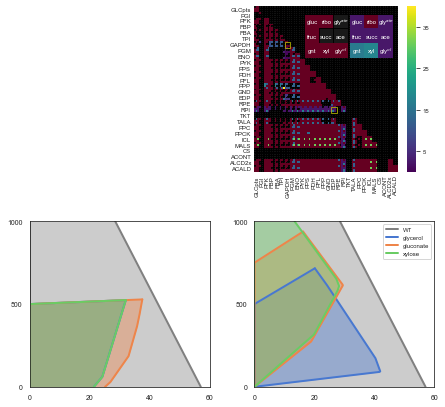

In [9]:
# Assembles the plot
fig = plt.figure(figsize=(7.25, 7))
sns.set_style('white')

gs = plt.GridSpec(2, 2, hspace=0.3, wspace=0.25)
ax = plt.subplot(gs[0,1])

my_cmap = cm.viridis

my_cmap.set_bad(color='black', alpha=0.9)
my_cmap.set_under(sns.xkcd_rgb['maroon'])

g = sns.heatmap(data_mat.T, vmin=0.01, vmax=40, cmap=my_cmap,
                cbar_kws={'label': '', 'ticks': np.arange(5, 36, 10)}, ax=ax)
g.set_facecolor('darkgrey')
cbar_axes = ax.figure.axes[-1]
#cbar_axes.set_ylabel('Coupling Slope', fontsize=9)
cbar_axes.tick_params(labelsize=6)

ax.set_xticks(np.arange(1.5, 3*N, 3))
ax.set_yticks(np.arange(1.5, 3*N, 3))
ax.set_xticklabels(SINGLE_KO_LABELS, rotation=90, ha='center', fontsize=6)
ax.set_yticklabels(SINGLE_KO_LABELS, rotation=0, va='center', fontsize=6)
ax.tick_params(pad=0)
    
rpi_idx = optslope_rubisco.SINGLE_KOS.index('RPI')
edp_idx = optslope_rubisco.SINGLE_KOS.index('EDD|EDA')
rect = patches.Rectangle((edp_idx*csource_dim-0.05, rpi_idx*csource_dim-0.05), 3.05, 3.00,
                         linewidth=2, edgecolor='y',facecolor='none', lw=0.75)
ax.add_patch(rect)

gap_idx = optslope_rubisco.SINGLE_KOS.index('GAPD|PGK')
rect = patches.Rectangle((gap_idx*csource_dim-0.05, gap_idx*csource_dim-0.05), 3.05, 3.00,
                         linewidth=2, edgecolor='y',facecolor='none', lw=0.75)
ax.add_patch(rect)

# Inset figure for EDD and GAP KOs. 
edp_start = edp_idx*csource_dim
rpi_start = rpi_idx*csource_dim
drpi_slopes = data_mat[edp_start:edp_start+3, rpi_start:rpi_start+3]

axins1 = inset_axes(ax, width="30%", height="30%", loc=1)
make_slopes_subplot(axins1, drpi_slopes, CARBON_SOURCE_LABELS)

gap_start = gap_idx*csource_dim
gap_slopes = data_mat[gap_start:gap_start+3, gap_start:gap_start+3]
axins2 = inset_axes(ax, width="30%", height="30%", loc=9)
make_slopes_subplot(axins2, gap_slopes, CARBON_SOURCE_LABELS)

# Plotting the phase spaces
colors = sns.color_palette('muted')

# gapA KO was previously published by Mueller-Cajar '07 and others.
# Plot shows that this strain has slope 0 on sample carbon sources.
csources_list = [
    (['dhap'], 'glycerol', colors[0]),
    (['6pgc'], 'gluconate', colors[1]),
    (['xu5p__D'], 'xylose', colors[2]),
]

mutant_list = [
    (["GAPD"], "ΔgapA"),
    (["RPI", "EDD"], "ΔrpiAB Δedd")
]

for j, (knockouts, mutant_name) in enumerate(mutant_list):
    my_ax = plt.subplot(gs[1, j])
    
    # plot wildtype
    plot_envelope(
            wt_model,
            knockouts=[],
            carbon_sources=rich_media,
            target_reaction="RBC",
            ax=my_ax,
            label='WT',
            color='grey')
    
    for csources, csource_name, c in csources_list:
        plot_envelope(
            wt_model,
            knockouts=knockouts,
            carbon_sources=csources,
            target_reaction="RBC",
            ax=my_ax,
            label=csource_name,
            color=c)
    
    #plt.title(mutant_name, fontsize=9, style='italic')
    plt.xlabel('', fontsize=9)
    plt.ylabel('', fontsize=9)
    plt.xlim(0, 60)
    plt.ylim(0, 1000)
    plt.xticks(np.arange(0, 61, 20), fontsize=7)
    plt.yticks(np.arange(0, 1001, 500), fontsize=7)
    
    if j == 1:
        plt.legend(loc="upper right", fontsize=6)

plt.savefig('notebooks/figS1/figS1.png', dpi=300)
plt.show()